# This is a part of the **practical exercise** on uncertainty for dermatoscopy classification. Your task is to go through this tutorial and fill in missing code and answer the questions.

---

First, as usual, we load needed libraries.

---


Authors:

Mohammed Elbushnaq, 03786474

Muhammed Elmasry, 03786399

Evangelos Fragkiadakis, 03786480

Nada Elsherbeny, 03788337


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision.transforms import ToTensor, Lambda

import numpy as np

In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=a19826885f734d587c232852bca5d9edc58df17e89e182ef14d362c1f7ab2b08
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


---

Now, let's load the dermatoscopy dataset from MedMNIST.

---



In [3]:
import medmnist
from medmnist import INFO, Evaluator

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, download=True)
test_set = DataClass(split='test', transform=data_transform, download=True)
train_set

100%|██████████| 19725078/19725078 [00:02<00:00, 9002749.65it/s] 


Using downloaded and verified file: /root/.medmnist/dermamnist.npz


Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


---

**Q1:** Next, we define objects of *DataLoader* class for training and testing splits. And we also define our model. Here it gets more challenging.

In the cell below you need to:

- load a resnet18 pretrained on ImageNet network from PyTorch
- add a Dropout layer to the last fully-connected layer with 25% probability of neurons to be zeroed
- change the last layer of the resnet18 such that it outputs 7 classes (the number of classes in the dermatoscopy dataset) instead of 1000 classes (as it is in the pretrained network)
- freeze all the layers except the last one, as we are gonna fine tune in the next step our pretrained network on the medical dataset

---

In [4]:
train_batch_size = 40
test_batch_size = 3

train_loader = DataLoader(
    train_set,
    batch_size=train_batch_size,
    num_workers=1,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=test_batch_size,
    num_workers=1,
    pin_memory=True,
)

# # PUT YOUR CODE HERE
model = resnet18(pretrained=True)

# Addding a Dropout layer to the last fully-connected layer, and changing its classes to 7
model.fc = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(model.fc.in_features, 7)
)

# Freezing all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Enable gradient computation for the last layer (FC Layer)
for param in model.fc.parameters():
    param.requires_grad = True

# The Modified model
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


---



Hope you made it work! Now we are gonna fine-tune the model (the last layer of it to be more precise).  

---

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = []
model.train()

for epoch in range(5):  # loop over the dataset 5 times to fine-tune the last layer

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Flatten labels to 1D to solve the runtime error (RuntimeError: 0D or 1D target tensor expected, multi-target not supported)
        labels = labels.squeeze()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # print(np.shape(outputs))
        # print(np.shape(labels))
        # print(labels.squeeze())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('\n Finished training')

100%|██████████| 176/176 [00:13<00:00, 13.09it/s]


 Finished training


**Q2:** What the heck? We got an error (`RuntimeError: 0D or 1D target tensor expected, multi-target not supported`).

Any idea how we can fix it?
**Yes, by just removing the extra dimention (squeeze) in the labels (I already did that in the above cell)**

---

Let's test the classification accuracy of our model.

**Q3:** Please fill in the missing code below. You need to loop over the test set and compute how many times the trained network predicts the class
correctly.

---

In [6]:
#  set model state to eval() for running the inference
model.eval()

correct = 0
total = 0
correcti = 0
totali = 0

with torch.no_grad():
  for images, labels in tqdm(test_loader):

# # PUT YOUR CODE HERE
        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Update total number of examples
        totali = labels.size(0)
        total += totali

        # Update number of correctly classified examples
        correcti = (predicted == labels.view(-1)).sum().item()
        correct += correcti

# Calculate accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


100%|██████████| 669/669 [00:13<00:00, 51.01it/s]

Test Accuracy: 69.53%


---

The accuracy is ok, but not mindblowing. Thus it would be useful, as discussed in the lecture, to know how confident our model is. Let's use Monte Carlo dropout to find out. We now run 1000 forward passes and look at the distribution of the predictions.

---

In [7]:
samples = 1000
preds = []
image = next(iter(test_loader))

# compute predictions from our model with dropout
for idx in range(samples):
    preds.append(model(image[0]).clone().detach().numpy())
    # print(image[0])
preds = np.array(preds)

In [ ]:
# Assuming test_loader is your DataLoader
# xx = len(test_loader)
# bs = test_loader.batch_size
# print(xx * bs)
# print(xx, bs)

# print(preds[0, 0])
# print(np.argmax(preds[0],1))

In [8]:
pred_class = []
for idx in range(preds.shape[0]):
    pred_class.append(np.argmax(preds[idx],1))

---

Now, we look at the results.

---



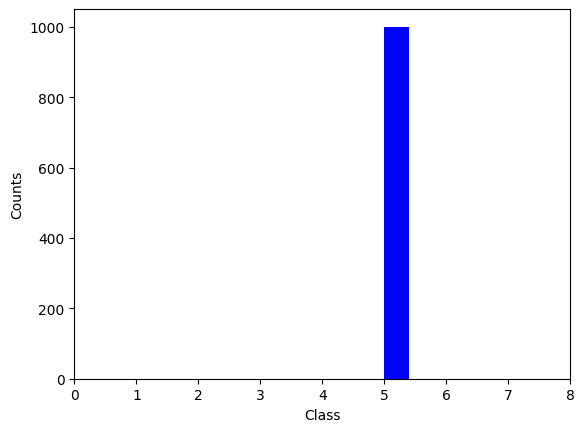

In [9]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist([x[0] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

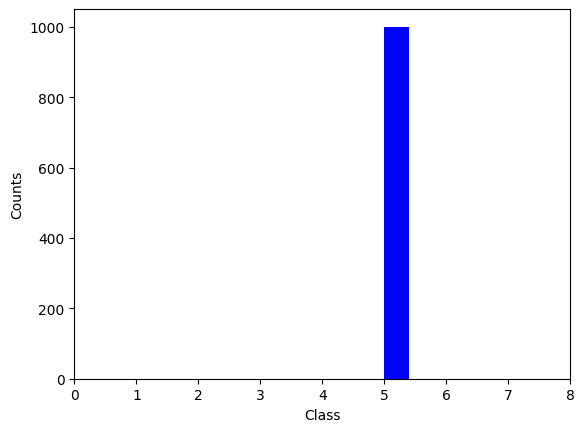

In [10]:
n, bins, patches = plt.hist([x[1] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

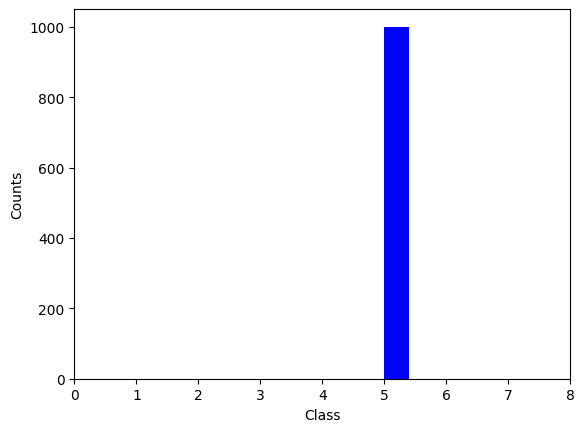

In [11]:
n, bins, patches = plt.hist([x[2] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

---

Hmm... each time, we predicted the same class 1000 times, but we expected the dropout to provide some distribution of predictions. Suspicuous...

**Q4:** Is there a catch? Please write your thoughts on why we do not see a distribution and whether we could fix it somehow.

**As the model deactivate the dropout during inference, to make deterministic predictions, so the model actually uses all of its neuron in the inference**

**What we need to do in Mote Carlo dropout, is to actually activate this dropout during the inference, so model.train() can be very suffecient to activate it, even if we are testing now not training.**

 **As we can see in the following 3 cells, the last two shows distributions of the predictions, but the first one doesn't (image[0]), that means that for all the combinations of the neurons with the 25% dropout, it predicts class 5 everytime**

---

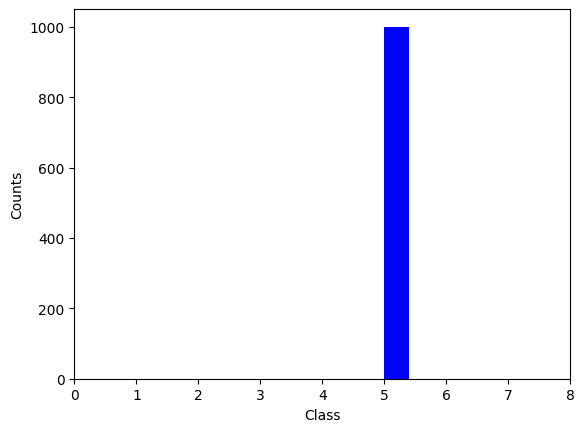

In [12]:
samples = 1000
preds = []
image = next(iter(test_loader))

model.train()
# compute predictions from our model with dropout
for idx in range(samples):
    preds.append(model(image[0]).clone().detach().numpy())
    # print(image[0])
preds = np.array(preds)

pred_class = []
for idx in range(preds.shape[0]):
    pred_class.append(np.argmax(preds[idx],1))

n, bins, patches = plt.hist([x[0] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

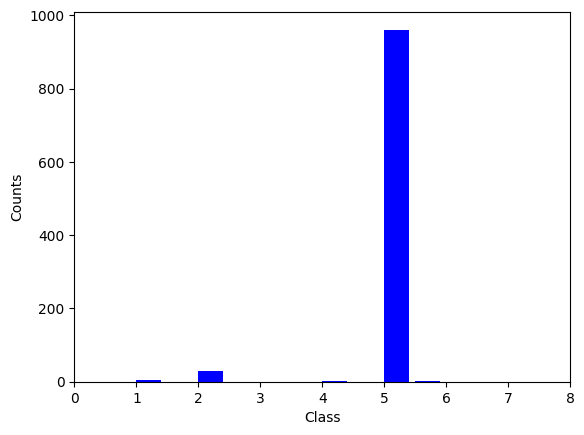

In [13]:
n, bins, patches = plt.hist([x[1] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

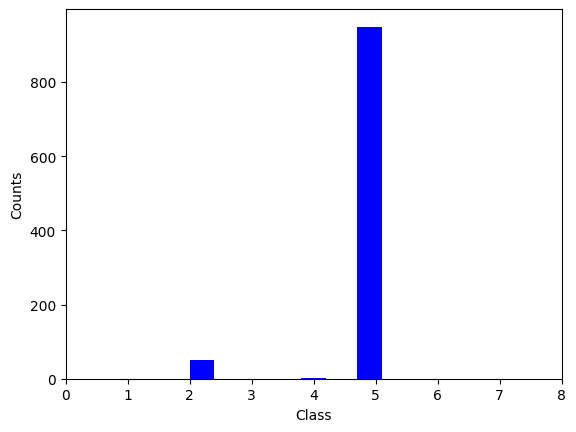

In [14]:
n, bins, patches = plt.hist([x[2] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()